In [10]:
import geopandas as gpd
from matplotlib import pyplot
import numpy as np
import pandas as pd
import pycrs
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject
from rasterio.mask import mask
from rasterio.plot import show

In [11]:
land_cover = {
    '1992': rasterio.open('data/LC9244097043/LC9244097043\LC9244097043.tif'),
    '2001': rasterio.open('data/LC0134842977/LC0134842977\LC0134842977.tif'),
    '2006': rasterio.open('data/LC0677649171/LC0677649171\LC0677649171.tif'),
    '2011': rasterio.open('data/LC1162809098/LC1162809098\LC1162809098.tif')
}

smith_county = gpd.read_file('data/county outline/county outline.shp')

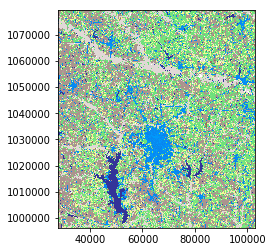

In [12]:
show((land_cover['2011'], 1), cmap='terrain')

In [16]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

mask_layer = smith_county.to_crs(crs=land_cover['2011'].crs.data)
mask_coords = getFeatures(mask_layer)

clipped = {}

for year, layer in land_cover.items():
    clipped_img, clipped_transform = mask(layer, shapes=mask_coords, crop=True)
    clipped_meta = layer.meta.copy()

    clipped_meta.update({
        "driver": "GTiff",
        "height": clipped_img.shape[1],
        "width": clipped_img.shape[2],
        "transform": clipped_transform
    })
    
    path = 'data/clipped_%s.tif' % year

    with rasterio.open(path, 'w', **clipped_meta) as dest:
        dest.write(clipped_img)
        
    clipped[year] = rasterio.open(path)

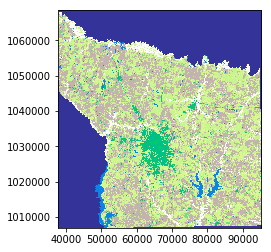

In [17]:
show((clipped['1992'], 1), cmap='terrain')

In [24]:
frames = []

for year, layer in clipped.items():
    data = layer.read(1)
    
    unique, counts = np.unique(data, return_counts=True)
    
    value_key = 'value_%s' % year
    count_key = 'count_%s' % year
    
    df = pd.DataFrame({
        value_key: unique,
        count_key: counts
    })
    
    df['class'] = df[value_key].map({
        11: 'Water',
        21: 'Developed',
        22: 'Developed',
        23: 'Developed',
        24: 'Developed',
        31: 'Barren',
        41: 'Forest',
        42: 'Forest',
        43: 'Forest',
        52: 'Shrubland',
        71: 'Herbaceous',
        81: 'Planted/Cultivated',
        82: 'Planted/Cultivated',
        90: 'Wetlands',
        95: 'Wetlands'    
    })
    
    df = df.groupby('class').agg({count_key: 'sum'})
    
    df['share'] = df[count_key] / sum(df[count_key]) * 100
    
    frames.append(df)

merged = frames[0]

for frame in frames[1:]:
    merged = merged.merge(frame, how='left', on='class')

In [26]:
merged.round(1)

,count_1992,share_x,count_2001,share_y,count_2006,share_x,count_2011,share_y
class,,,,,,,,
Barren,10618,0.4,2010,0.1,9588,0.4,9771,0.4
Developed,143696,5.7,370848,13.6,381892,14.0,400644,14.7
Forest,1231351,48.7,914306,33.4,871390,31.9,870876,31.9
Herbaceous,581,0.0,840,0.0,6704,0.2,27390,1.0
Planted/Cultivated,1072905,42.4,740966,27.1,733489,26.8,729277,26.7
Water,71207,2.8,71828,2.6,68706,2.5,69015,2.5


In [ ]:
src = clipped['2011']
arr = src.read()
newarr = np.empty(shape=(arr.shape[0],  # same number of bands
                         round(arr.shape[1] * 0.005), # 150% resolution
                         round(arr.shape[2] * 0.005)))

# adjust the new affine transform to the 150% smaller cell size
aff = src.transform
newaff = rasterio.Affine(aff.a / 0.005, aff.b, aff.c,
                aff.d, aff.e / 0.005, aff.f)

reproject(
    arr, newarr,
    src_transform = aff,
    dst_transform = newaff,
    src_crs = src.crs,
    dst_crs = src.crs,
    resampling = Resampling.mode)

newarr = newarr.astype(np.uint8)

meta = src.meta.copy()

meta.update({
    "transform": newaff
})

with rasterio.open('data/reprojected.tif', "w", **meta) as dest:
    dest.write(newarr)

In [ ]:
reprojected = rasterio.open('data/reprojected.tif')

show((reprojected, 1), cmap='terrain')